# Stable Diffusion and Inpainting Project

## 1. Installing dependencies

In [6]:
!pip install transformers
!pip install PIL
!pip install diffusers
!pip install accelerate

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


## 2. Loading libraries

In [7]:
from transformers import AutoProcessor, CLIPSegForImageSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch
from torch import autocast
import cv2
from diffusers import StableDiffusionInpaintPipeline as StableDiffusionInpaintPipeline
from torch.cuda.amp import autocast
import PIL
from io import BytesIO

## 3. Loading the model

In [21]:
device = "cuda"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    variant="fp16", 
    torch_dtype=torch.float16,
).to(device)
processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


## 4. Defining the inpainting function  

In [14]:
def inpainting():
    images_url = input("Enter the image's url or path: ") # input image from user
    try:
        input_image = Image.open(requests.get(images_url, stream=True).raw)
    except:
        input_image = Image.open(images_url)
    input_image.show()
    text = input("What do you want to replace? ") # 
    texts = [text]+[""]
    inputs = processor(text=texts, images=[input_image]*len(texts), padding=True, return_tensors="pt")

    #predicting the position of the queried object in the picture as a heatmap
    with torch.no_grad():
        outputs = model(**inputs)

    predictions = outputs.logits.unsqueeze(1)
    
    # saving the heatmap as a black and white image
    filename = f"mask.png"
    plt.imsave(filename,torch.sigmoid(predictions[0][0]))
    img2 = cv2.imread(filename)
    gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # transforming the black and white heatmap in a binary mask
    while True:
        threshold_value = input("Select a threshold value between 0 and 255: ")
        (thresh, bw_image) = cv2.threshold(gray_image, int(threshold_value), 255, cv2.THRESH_BINARY)
        Masking = Image.fromarray(bw_image)
        Masking.show()
        confirmation = input("Happy with the mask? Y/N")
        if confirmation.upper() == "Y":
            break
    
    #prompt generation for the inpainting
    prompt = input("What do you want to replace the object with? ")

    guidance_scale=7.5
    num_samples=20
    generator = torch.Generator(device="cuda").manual_seed(0)
    generated_image = pipe(
        prompt=prompt, 
        image=input_image, 
        mask_image=Masking,
        guidance_scale=guidance_scale,
        generator=generator,
        num_images_per_prompt=num_samples,
    )
    return generated_image
    

## 5.Testing the function

Enter the image's url or path: dog-pic.jpg


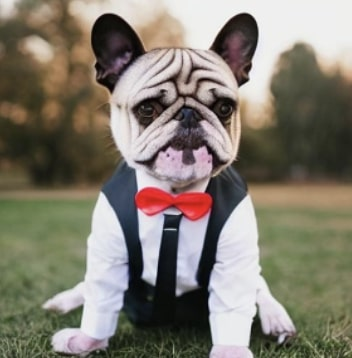

What do you want to replace? shirt
Select a threshold value between 0 and 255: 80


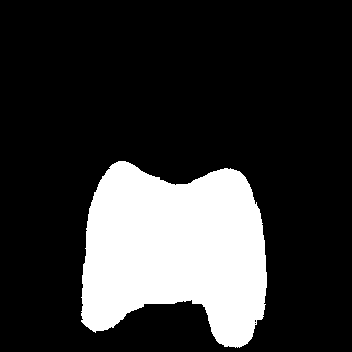

Happy with the mask? Y/Ny
What do you want to replace the object with? a green raincoat


  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
y=inpainting()

## 6. Results

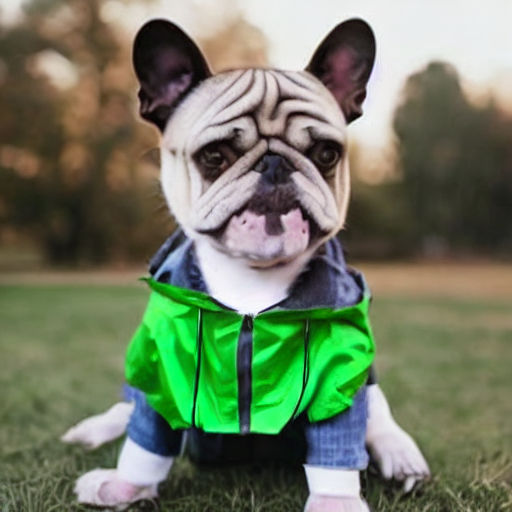

In [28]:
y.images[3]

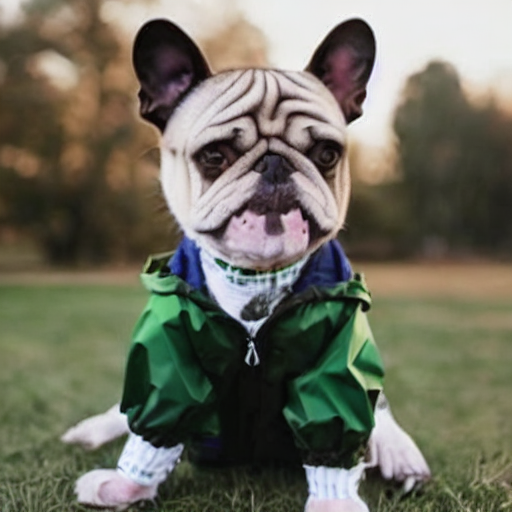

In [29]:
y.images[7]

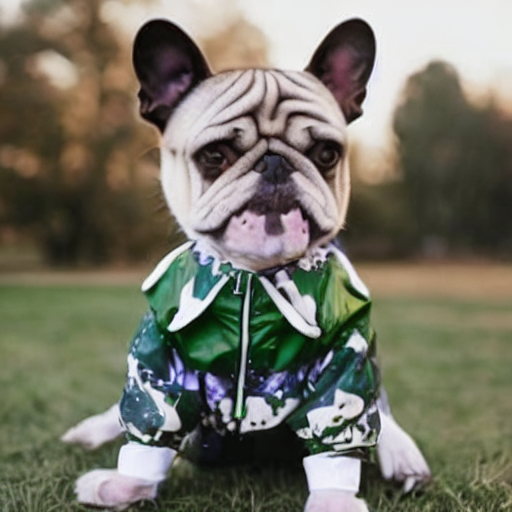

In [31]:
y.images[8]